# Setup

In [1]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
options(warn = -1)
require("pacman")
pacman::p_load(tidyverse, ggplot2, latex2exp, fpp2, 
               ggfortify, ggpubr, zoo, lubridate, mgcv,
               aod, tseries, xts, vars)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

Loading required package: pacman



# Creating Merged Time Series

,homeownership,price,gdp,interest
homeownership,1.0000000,0.2072627,0.3024910,-0.2188913
price,0.2072627,1.0000000,0.9784339,-0.7881139
gdp,0.3024910,0.9784339,1.0000000,-0.8357028
interest,-0.2188913,-0.7881139,-0.8357028,1.0000000


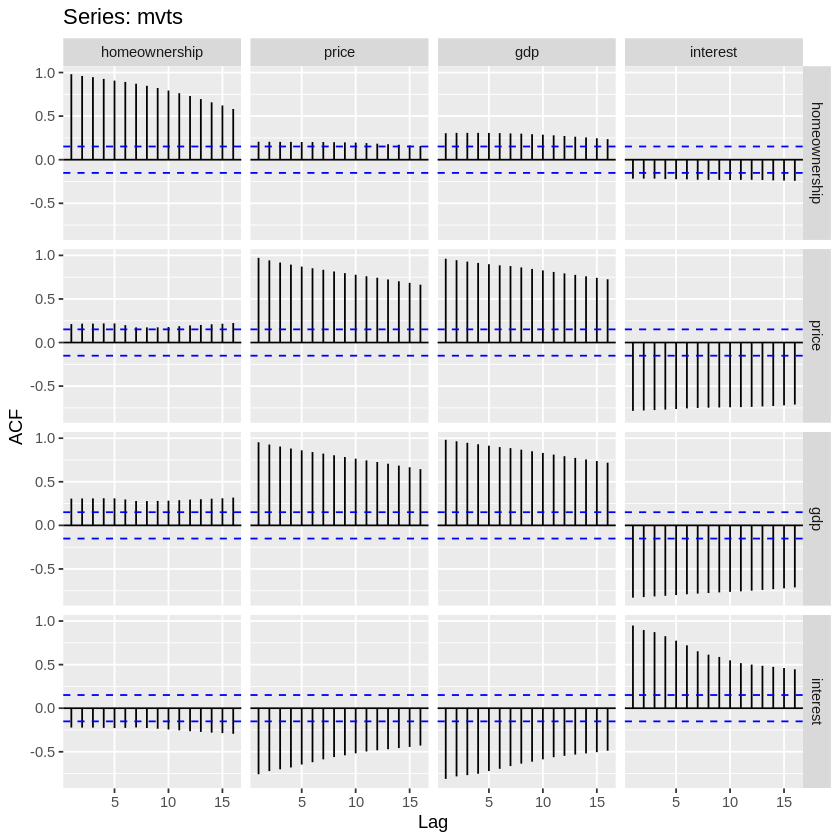

In [2]:
homeownership <- read_homeownership()
price <- read_sales_price()
gdp <- read_gdp()
interest <- read_interest_rate()

homeownership <- xts(x = homeownership$Value, order.by = homeownership$Date)
price <- xts(x = price$Price, order.by = price$Date)
gdp <- xts(x = gdp$GDP, order.by = gdp$Date)
interest <- xts(x = interest$Rate, order.by = interest$Date)
breaks <- head(endpoints(interest, 'quarters')+1, -1)
interest <- period.apply(interest, breaks, mean)

mvts <- merge(homeownership, price, join = 'inner') %>%
        merge(gdp, join = 'inner') %>%
        merge(interest, join = 'inner')

cor(mvts)
ggAcf(mvts)

# VAR Modelling

## Creating VAR Model

In [3]:
test_split <- 4
train <- head(mvts, -test_split)
test <- tail(mvts, test_split)

In [4]:
var_orders <- VARselect(train, lag.max = 20)$selection %>% as.data.frame
var_orders
var_model <- VAR(mvts, p = var_orders[1,1])

n_terms <- var_model$K * var_model$p

ho_vcov <- vcov(var_model$varresult$homeownership)
ho_vcov <- ho_vcov[-nrow(ho_vcov), -ncol(ho_vcov)]
ho_eq_coeff <- coefficients(var_model)$homeownership[1:n_terms,1]
wald.test(b = ho_eq_coeff, Sigma = ho_vcov, Terms = (var_model$K+1):n_terms)


,.
,<int>
AIC(n),3
HQ(n),3
SC(n),2
FPE(n),3


Wald test:
----------

Chi-squared test:
X2 = 27.7, df = 8, P(> X2) = 0.00054

Keep using larger order VAR model since extra terms in homeownership equation are not 0 given Wald test

In [15]:
tests <- list(var_model$K-1)
for (i in 2:var_model$K) {
    this_test <- wald.test(ho_eq_coeff, Sigma = ho_vcov, Terms = seq(from = i, to = n_terms, by = var_model$K))
    tests[[i-1]] <- this_test
}
names(tests) <- names(var_model$varresult)[-1]
tests

$price
Wald test:
----------

Chi-squared test:
X2 = 7.6, df = 3, P(> X2) = 0.055

$gdp
Wald test:
----------

Chi-squared test:
X2 = 28.1, df = 3, P(> X2) = 3.4e-06

$interest
Wald test:
----------

Chi-squared test:
X2 = 3.4, df = 3, P(> X2) = 0.34


Quarterly change in GDP Granger-causes quarterly change in Homeownership rate

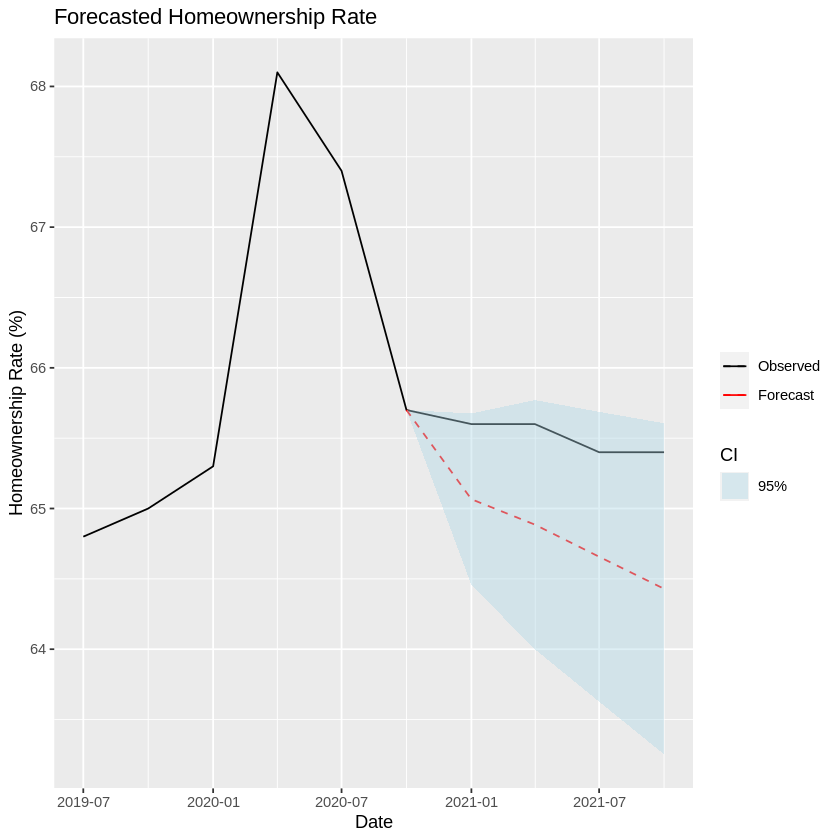

In [8]:
var_pred <- predict(var_model, n.ahead = 4, level = c(95))$fcst$homeownership %>% as.data.frame %>% dplyr::select(-CI)
connect <- as.data.frame(train)$homeownership %>% tail(1)
var_pred <- rbind(rep(connect, ncol(var_pred)), var_pred)
var_pred$Date <- c(tail(time(train),1), time(test))

data <- mvts %>% as.data.frame %>% rownames_to_column("Date")
data$Date <- as.Date(data$Date, format = "%Y-%m-%d")
data %>% tail(10) %>% ggplot() +
    geom_line(aes(x = Date, y = homeownership, color = "Observed")) +
    geom_line(data = var_pred, aes(x = Date, y = fcst, color = "Forecast"), linetype = "dashed") +
    geom_ribbon(data = var_pred, aes(x = Date, ymin = upper , ymax = lower, fill = "95%"), alpha = 0.4) +
    labs(x = "Date", y = "Homeownership Rate (%)", title = "Forecasted Homeownership Rate") +
    scale_color_manual("", values = c("Observed" = "black", "Forecast" = "red")) +
    scale_fill_manual("CI", values = c("95%" = "lightblue"))

In [7]:
accuracy(tail(var_pred, -1)$fcst, x = test$homeownership)
cat("PM = ", prec_measure(test$homeownership, tail(var_pred, -1)$fcst))

,ME,RMSE,MAE,MPE,MAPE
Test set,0.740547,0.7566094,0.740547,1.13088,1.13088


PM =  57.24578